Necessary files:
CellFateModel.bnd
CellFateModel.cfg
CellFate.upp

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os

import maboss
import subprocess

# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

# Simulation of wild type model

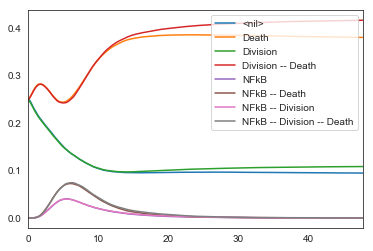

In [2]:
# Set up the required files
bnd_file ="CellFateModel.bnd"
cfg_WT = "CellFateModel_1h.cfg"
upp_file = "CellFate_1h.upp"
workdir  = "WT"

# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})

# for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
#     model_48h.network[name].is_internal = True

model_48h.network.set_output(('Death','Division','NFkB'))
run_48h = model_48h.run()

run_48h.get_states_probtraj().plot()


According to result above, consider Time Step >= 1

Step ratio: 1
Step ratio: 2
Step ratio: 3
Step ratio: 4


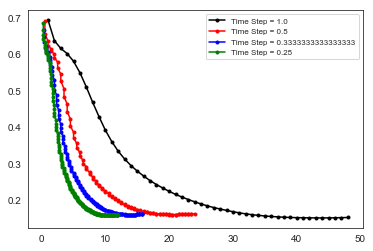

In [3]:
max_time = model_WT.param["max_time"]
time_tick = model_WT.param["time_tick"]

ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()
for ratio,color in ratios.items():
    print("Step ratio:", ratio)
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model = maboss.copy_and_update_parameters(model_WT, params)

#     # Also adapt the number of time steps in the upp file
#     # TODO: python API to manipulate the upp file
#     step_upp_file = upp_file.replace(".upp","_R"+str(ratio)+".upp")
#     of = open(upp_file,'r')
#     mf = open(step_upp_file,'w')
#     for line in of:
#         mf.write(line.replace("steps = 48","steps = "+str(48*ratio)))
#     of.close()
#     mf.close()

    # Run UpPMaBoSS on the modified setup
    rwd = "%s_R%s" % (workdir, ratio)
    uppModel_step = maboss.UpdatePopulation(step_model, upp_file)
    
    # TODO: python API to manipulate the upp file : Done
    uppModel_step.setStepNumber(48*ratio)
    
    run_step = uppModel_step.run(rwd)
    pop_ratios = run_step.get_population_ratios()
    pop_ratios = pop_ratios[1:]
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()

Asymptotic beahvior of population is robust, but not transient reduction. Therefore, Time Step sensitivity should be considered. for fitting a real population of cel

# Simulation of model with no TNF

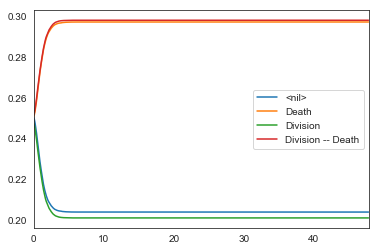

In [4]:
#Create a model for 48h with no TNF

model_48h_noTNF = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
model_48h_noTNF.network.set_istate('TNF',[1,0])

for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h_noTNF.network[name].is_internal = True

model_48h_noTNF.network.set_output(('Death','Division','NFkB'))
run_48h_noTNF = model_48h_noTNF.run()

run_48h_noTNF.get_states_probtraj().plot()

Behavior is stable (NFkB is not shown because it is always at 0). Consider also Time Step >= 1.

Step ratio: 1
Step ratio: 2
Step ratio: 3
Step ratio: 4


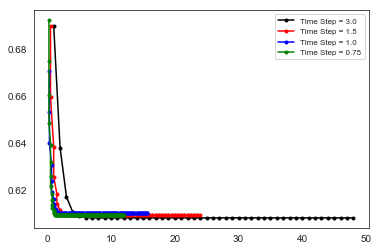

In [5]:
model_WT_noTNF = model_WT.copy()
model_WT_noTNF.network.set_istate('TNF',[1.0,0.0])
ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()

upp_sims = []
for ratio,color in ratios.items():
    print("Step ratio:", ratio)
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model_noTNF = maboss.copy_and_update_parameters(model_WT_noTNF, params)

    # Also adapt the number of time steps in the upp file
    # TODO: python API to manipulate the upp file
    step_upp_file = upp_file.replace(".upp","_R"+str(ratio)+".upp")
    #of = open(upp_file,'r')
    #mf = open(step_upp_file,'w')
    #for line in of:
    #    mf.write(line.replace("steps = 16","steps = "+str(16*ratio)))
    #of.close()
    #mf.close()

    # Run UpPMaBoSS on the modified setup
    rwd = "%s_noTNF_R%s" % (workdir, ratio)
    uppModel_step_noTNF = maboss.UpdatePopulation(step_model_noTNF, step_upp_file)
    run_step_noTNF = uppModel_step_noTNF.run(rwd)
    upp_sims.append(run_step_noTNF)
    
    
    pop_ratios = run_step_noTNF.get_population_ratios()
    pop_ratios = pop_ratios[1:]

    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(3/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()


Behavior is robust. Plot time < 10.

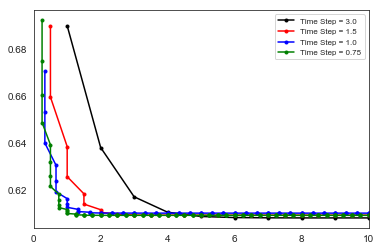

In [6]:
fig, ax = plt.subplots()
for i, (ratio,color) in enumerate(ratios.items()):
    pop_ratios = upp_sims[i].get_population_ratios()
    pop_ratios = pop_ratios[1:]
    
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(3/ratio),c=color)
plt.xlim(0,10)
ax.legend(loc='upper right',prop={'size':8})
plt.show()
